## Load packages

In [75]:
import warnings
warnings.filterwarnings('ignore')
import shutil
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from brainspace.utils.parcellation import map_to_labels
import cmasher as cmr
from sklearn.metrics import mean_absolute_error as mae
import func_utils as fu

In [76]:
# change pattern and l1_position
pattern = 'inter'; l1=0; score = 'ados'

### Model selection from train-test splits (python processed)

In [77]:
data = [None] * 10
for i in range(10):
  data[i] = np.load('../results/prediction_EN/'+pattern+'/'+score+'_l1ratio_'+str((i+1)/10)+'.npy', 
                    allow_pickle=True).item()

coef = [[v['importance'] for k, v in data[i].items()] for i in range(10)]
train_r_p = [[v['predict_train_r_p'] for k, v in data[i].items()] for i in range(10)]
test_r_p = [[v['predict_test_r_p'] for k, v in data[i].items()] for i in range(10)]
y_train = [[v['y_train'] for k, v in data[i].items()] for i in range(10)]
y_test = [[v['y_test'] for k, v in data[i].items()] for i in range(10)]
y_pred_train = [[v['y_pred_train'] for k, v in data[i].items()] for i in range(10)]
y_pred_test = [[v['y_pred_test'] for k, v in data[i].items()] for i in range(10)]

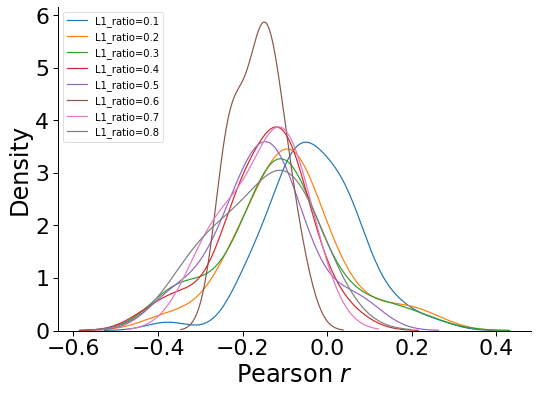

In [78]:
fu.test_r_displot(test_r_p)
plt.savefig('../figures/EN_L1line_'+score+pattern+'.png', dpi=300, transparent=True)

In [79]:
mae_test = np.zeros(100)
mae_train = np.zeros(100)
for i in range(100):
    mae_test[i] = mae(y_test[l1][i], y_pred_test[l1][1])
    mae_train[i] = mae(y_train[l1][i], y_pred_train[l1][1])

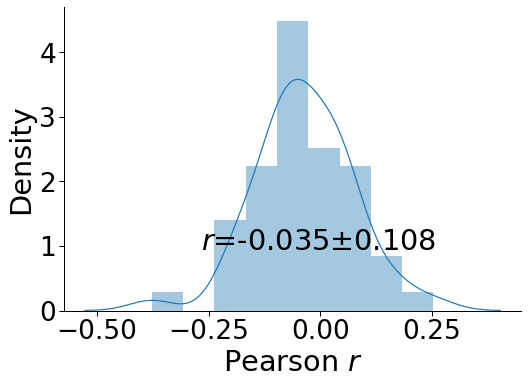

In [80]:
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(1, figsize=(8,6))
#leg = ['Test', 'Train']
sns.distplot(np.array(test_r_p)[l1][:,0], ax=ax, label='Test')
#sns.distplot(np.array(train_r_p)[l1][:,0], ax=ax, label='Train')
#plt.legend(loc='upper left', markerscale=0.7, scatterpoints=1, fontsize=14)
ax.set_xlabel('Pearson $\it{r}$')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
mean = np.nanmean(np.array(test_r_p)[l1][:,0])
std = np.nanstd(np.array(test_r_p)[l1][:,0])
ax.text(0.3, 0.2, '$\it{r}$='+'%.3f'%mean+'±%.3f'%std, transform=ax.transAxes)
fig.tight_layout()
plt.savefig('../figures/EN_pred_train_test_r_'+score+pattern+'.png', dpi=300, transparent=True)

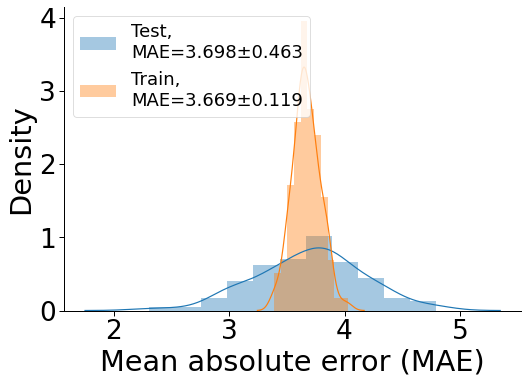

In [81]:
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(1, figsize=(8,6))
sns.distplot(mae_test, ax=ax, label='Test, \nMAE='+'%.3f'%np.nanmean(mae_test)+'±'+'%.3f'%np.nanstd(mae_test))
sns.distplot(mae_train, ax=ax, label='Train, \nMAE='+'%.3f'%np.nanmean(mae_train)+'±'+'%.3f'%np.nanstd(mae_train))
plt.legend(loc='upper left', markerscale=0.5, scatterpoints=1, fontsize=18)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Mean absolute error (MAE)')
plt.tight_layout()
plt.savefig('../figures/EN_mae_train_test_'+score+pattern+'.png', dpi=300, transparent=True)

In [82]:
med = min(mae_test, key=lambda x: abs(x-np.nanmedian(mae_test)))

In [83]:
# frequeenycy sum-ed by all 100 models
select_fre = np.array(coef[l1].copy())
select_fre[select_fre != 0] = 1
select_model = select_fre.sum(axis=0)

In [84]:
# if we want to select median as final model
# med = min(mae_test, key=lambda x: abs(x-np.nanmedian(mae_test)))
# med_num = int(np.where(mae_test == med)[0])
# select_model_med = coef[l1][med_num].copy()
# select_model[select_model_med == 0] = 0

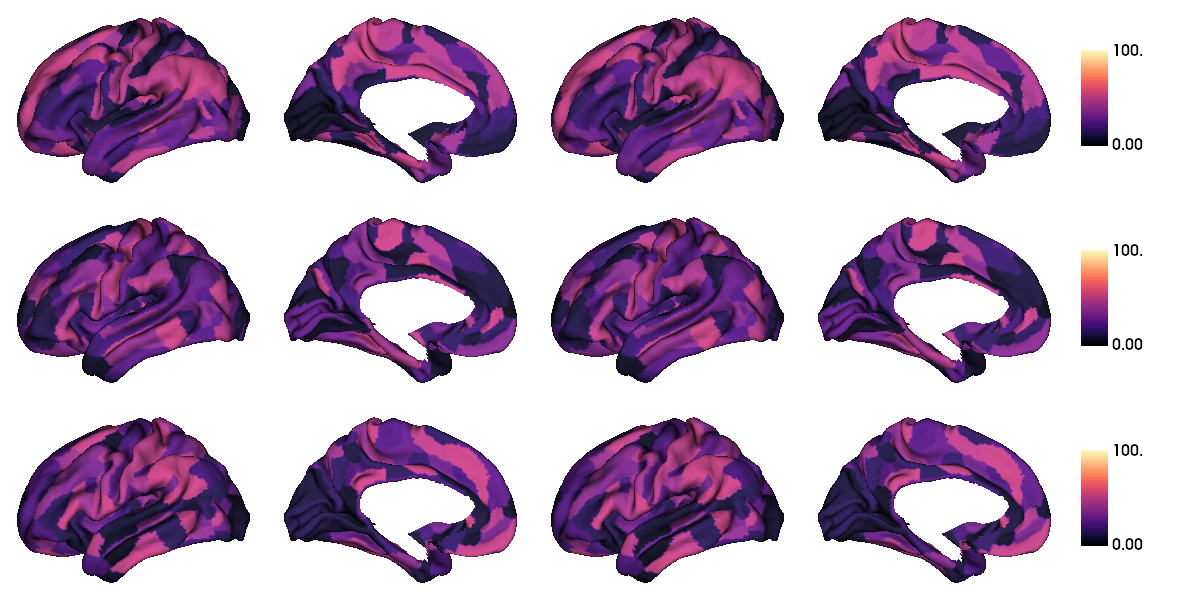

In [85]:
mask = fu.mmp_ll != 0
plot_select = [select_model[:180],select_model[180:360], select_model[360:]]
plot = [None] * 3
for i in range(3):
  plot[i] = map_to_labels(np.concatenate((plot_select[i],plot_select[i])), fu.mmp_ll, mask=mask)
  plot[i][plot[i]==0]=np.nan
max=abs(select_model).max()
fu.plot_surface_ll(data=plot, size=(1200,600), cmap='magma', color_range=(0, 100), 
                   filename='../figures/EN_pred_select_feature_'+score+pattern+'.png')

In [86]:
ca_select = np.zeros((12,3))
for i in range(3):
  for j in range(12):
    ca_select[j,i] = abs(plot_select[i][fu.ca[:180]==j+1]).mean()
ca_select

array([[19.        , 21.        , 12.        ],
       [25.48148148, 30.74074074, 22.92592593],
       [29.21052632, 29.21052632, 31.78947368],
       [35.33333333, 27.62962963, 30.2962963 ],
       [28.66666667, 34.33333333, 30.58333333],
       [27.07142857, 27.        , 30.07142857],
       [30.59090909, 24.86363636, 31.13636364],
       [22.875     , 24.125     , 26.375     ],
       [34.05      , 27.075     , 25.75      ],
       [40.        , 29.33333333, 10.33333333],
       [27.5       , 18.        , 23.        ],
       [29.33333333, 24.33333333, 21.66666667]])

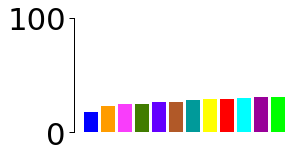

In [87]:
fu.plot_t_single(ca_select.mean(axis=1), thres=100, filename= '../figures/EN_ML_ca_'+score+pattern+'.png')

In [88]:
#fu.ca_radar_3g(ca_select, width=650, filename='../figures/EN_ML_ca_'+score+pattern)
#import time
#time.sleep(3)
#shutil.copy('../../../../Downloads/plot_image.svg', '../figures/EN_ML_ca_'+score+pattern+'.svg')
#time.sleep(2)
#os.remove('../../../../Downloads/plot_image.svg')
#os.remove('../figures/EN_ML_ca_'+score+pattern+'.html')